## Packages for training the model and working with the dataset.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Utility/helper packages.

In [3]:
import platform
import time
import pathlib
import os

## Checking verions of python, tensorflow and keras.

In [4]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.3.0
Keras version: 2.4.0


## Importing and storing Dataset.


## Merging Datasets of different websites into one for training purposes.

**json.load()** takes a file object and returns the json object. A JSON object contains data in the form of key/value pair. The keys are strings and the values are the JSON types. Keys and values are separated by a colon. Each entry (key/value pair) is separated by a comma.

In [5]:
def load_dataset(silent=False):
    # List of dataset files we want to merge.
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'/content/gdrive/My Drive/Homemade RecipeBowl/Datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file) 
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            # This code block outputs the summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

In [6]:
dataset_raw = load_dataset() 

/content/gdrive/My Drive/Homemade RecipeBowl/Datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingr

## Total Training Examples collected.

In [7]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


## Preprocessing the dataset
#### Filtering out incomplete examples

In [8]:
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

#### Final Dataset Count

In [9]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of incomplete recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of incomplete recipes 2226


## Converting recipes objects into strings

RNN doesn't understand objects. Therefore, we need to convert recipes objects to string and then to numbers (indices). Let's start with converting recipes objects to strings.

To help our RNN learn the structure of the text faster, let's add 3 "landmarks" to it. We will use these unique "title", "ingredients" and "instruction" landmarks to separate the logic sections of each recipe.

In [10]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

### The following function converts the recipe object to a string (sequence of characters) for later usage in RNN input.

#### Before Preprocessing

In [11]:
print(dataset_validated[0])

{'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'}


#### Function

In [12]:
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'    # adding bullets to structure the data
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'    # adding bullets to structure the data
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'


#### After Preprocessing: Stop words added, noise(unnecessary) words removed

In [13]:
print(recipe_to_string(dataset_validated[0]))

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



In [14]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [15]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [16]:
print(dataset_stringified[50000])

📗 Herbed Bean Ragoût 

🥕

• 6 ounces haricots verts (French thin green beans), trimmed and halved crosswise
• 1 (1-pound) bag frozen edamame (soybeans in the pod) or 1 1/4 cups frozen shelled edamame, not thawed
• 2/3 cup finely chopped onion
• 2 garlic cloves, minced
• 1 Turkish bay leaf or 1/2 California bay leaf
• 2 (3-inch) fresh rosemary sprigs
• 1/2 teaspoon salt
• 1/4 teaspoon black pepper
• 1 tablespoon olive oil
• 1 medium carrot, cut into 1/8-inch dice
• 1 medium celery rib, cut into 1/8-inch dice
• 1 (15- to 16-ounces) can small white beans, rinsed and drained
• 1 1/2 cups chicken stock or low-sodium broth
• 2 tablespoons unsalted butter
• 2 tablespoons finely chopped fresh flat-leaf parsley
• 1 tablespoon finely chopped fresh chervil (optional)
• Garnish: fresh chervil sprigs

📝

▪︎ Cook haricots verts in a large pot of boiling salted water until just tender, 3 to 4 minutes. Transfer with a slotted spoon to a bowl of ice and cold water, then drain. Add edamame to boiling wa

## Filtering out large recipes

Recipes have different lengths. We need to have one hard-coded sequence length limit before feeding recipe sequences to RNN. We need to find out what recipe length will cover most of the recipe use-cases, and at the same time, we want to keep it as small as possible to speed up the training process.

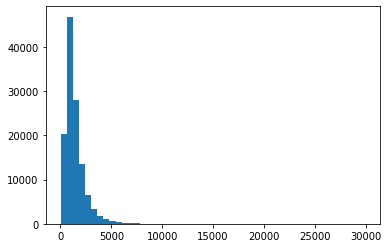

In [17]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

Most of them fewer then 5000. Let's focus on a particular range

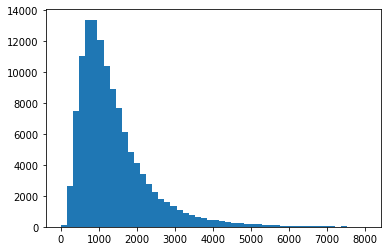

In [18]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

## Let's take 2000 characters as our maximum considering they would cover most of the recipes

In [19]:
MAX_RECIPE_LENGTH = 2000

In [20]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered)) 

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of eliminated recipes:  22726


## Datasets after being preprocessed

In [21]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100212


## Creating vocabulary

The recurrent neural network doesn't understand the characters or words. It understands numbers instead. Therefore, we need to convert recipe texts to numbers.

We're going to use a character-level language model based on multi-layer LSTM (Long Short-Term Memory) network (as opposed to the word-level language model). This means that instead of creating unique indices for words, we will create unique indices for characters. By doing that we let the network predict the next character instead of the next word in a sequence.

#### To create a vocabulary out of recipes texts, we will use tf.keras.preprocessing.text.Tokenizer.

In [22]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'char_level': True,
 'document_count': 100213,
 'filters': '',
 'index_docs': '{"1": 100212, "165": 1, "66": 24377, "53": 100212, "62": 35206, "26": 99320, "22": 98331, "31": 100212, "9": 100204, "11": 100194, "2": 100212, "32": 100212, "7": 100207, "52": 100212, "13": 100190, "4": 100202, "21": 100163, "17": 99988, "5": 100205, "64": 31908, "15": 100046, "43": 67614, "3": 100205, "18": 99975, "27": 97848, "40": 65486, "51": 100212, "8": 100207, "19": 99702, "34": 82453, "42": 67627, "37": 79135, "58": 40870, "33": 89250, "24": 100212, "12": 100161, "16": 100212, "10": 100206, "25": 97316, "23": 99227, "14": 100161, "29": 96743, "35": 83328, "41": 61954, "39": 79364, "20": 98524, "6": 100198, "44": 60900, "28": 96387, "54": 46675, "30": 89051, "38": 72133, "63": 32101, "60": 37000, "50": 54040, "71": 14114, "55": 48332, "48": 57940, "47": 47438, "45": 64278, "36": 74711, "73": 9981, "76": 5819, "49": 53758, "57": 36538, "59": 38981, "56": 33863, "68": 18120, "46": 42430, "61": 35355, 

To get a full size of a vocabulary we need to add +1 to the number of already registered characters because index 0 is a reserved index that won't be assigned to any word.

In [23]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


In [24]:
for i in range(1,176):
  print(tokenizer.index_word[i],end=" ")

  e a t o n i r s l d h c u p 
 m g b , . f w • k 1 v y 2 / ▪ ︎ S 4 C - 3 x P 5 0 ( ) A B z j F T R 📗 🥕 📝 I M ; q D W 8 G 6 L H : 7 O ' E K 9 U N V J ® ° é " Y Q * ! Z – & % ñ è ™ î X ? ¿ — ç # ½ í = ’ â © ¼ + > $ < á ó ú ï É û ] [ ü ê à _ ­ ¾ ‚ � º ⁄ ä Ú ù ́ } ö { ì ô  ” × ˚ » @ § \ ◊ ‱ “ ‧ ‭ ⅛ å ﬂ ` Á ë   ø ⅓ | ư  ´ ‒ Â ␣ ¤ ‟   ơ ă ̀ ⅞ € ~  

In [25]:
tokenizer.word_index['r']

8

To illustrate what kind of characters form all the recipes in our dataset we may print all of them as an array:


In [26]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', '📗', '🥕', '📝', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '?', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'á', 'ó', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', 'à', '_', '\xad', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', 'Á', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '␣', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


tokenizer functions to convert text to indices:

In [27]:
tokenizer.texts_to_sequences(['📗 yes'])

[[51, 1, 28, 2, 9]]

## Vectorizing the dataset
 
Now, once we have a vocabulary (character --> code and code --> character relations), we may convert the set of recipes from text to numbers (RNN works with numbers as an input and not with the texts).

In [28]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized)) 

Vectorized dataset size 100212


In [29]:
dataset_vectorized[0]

[51,
 1,
 33,
 10,
 5,
 23,
 1,
 35,
 5,
 5,
 25,
 2,
 8,
 1,
 35,
 12,
 7,
 13,
 25,
 2,
 6,
 1,
 3,
 6,
 11,
 1,
 58,
 14,
 17,
 15,
 10,
 7,
 6,
 18,
 9,
 16,
 16,
 52,
 16,
 16,
 24,
 1,
 34,
 1,
 9,
 25,
 7,
 6,
 10,
 2,
 9,
 9,
 20,
 1,
 19,
 5,
 6,
 2,
 10,
 2,
 9,
 9,
 1,
 13,
 12,
 7,
 13,
 25,
 2,
 6,
 1,
 19,
 8,
 2,
 3,
 9,
 4,
 1,
 12,
 3,
 10,
 27,
 2,
 9,
 1,
 16,
 24,
 1,
 29,
 1,
 4,
 3,
 19,
 10,
 2,
 9,
 15,
 5,
 5,
 6,
 9,
 1,
 19,
 14,
 4,
 4,
 2,
 8,
 1,
 16,
 24,
 1,
 29,
 1,
 42,
 26,
 41,
 21,
 66,
 40,
 1,
 5,
 14,
 6,
 13,
 2,
 43,
 1,
 13,
 3,
 6,
 9,
 1,
 13,
 5,
 6,
 11,
 2,
 6,
 9,
 2,
 11,
 1,
 13,
 8,
 2,
 3,
 17,
 1,
 5,
 22,
 1,
 13,
 12,
 7,
 13,
 25,
 2,
 6,
 1,
 9,
 5,
 14,
 15,
 1,
 16,
 24,
 1,
 26,
 1,
 5,
 6,
 7,
 5,
 6,
 20,
 1,
 22,
 7,
 6,
 2,
 10,
 28,
 1,
 11,
 7,
 13,
 2,
 11,
 1,
 16,
 24,
 1,
 29,
 1,
 42,
 26,
 41,
 1,
 5,
 14,
 6,
 13,
 2,
 43,
 1,
 15,
 3,
 13,
 25,
 3,
 18,
 2,
 9,
 1,
 8,
 2,
 22,
 8,
 7,
 18,
 2,
 8,
 3,
 4,
 2,
 

In [30]:
print(dataset_vectorized[0][:10], '...')

[51, 1, 33, 10, 5, 23, 1, 35, 5, 5] ...


In [31]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r .   C o o k   u n 

## Add padding to sequences

We need all recipes to have the same length for training. To do that we'll use tf.keras.preprocessing.sequence.pad_sequences utility to add a stop word to the end of each recipe and to make them have the same length.

In [32]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


Let's pad all recipes with a STOP_SIGN:

In [33]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded_without_stops[0][:15])

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded[0][:17])

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

[51  1 33 10  5 23  1 35  5  5 25  2  8  1 35]
[51  1 33 10  5 23  1 35  5  5 25  2  8  1 35 12  7]
Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [34]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r .   C o o k   u n 

## Create TensorFlow dataset

Up until now, we were working with the dataset as with the NumPy array. It will be more convenient during the training process if we will convert a dataset NumPy array to a TensorFlow dataset. It will give us an ability to use such helpers functions as batch(), shuffle(), repeat(), prefetch() etc.:

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [36]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t 

## Split examples on input and target texts

For each sequence, we need to duplicate and shift it to form the input and target texts. For example, say the sequence_length is 4, and our text is Hello. The input sequence would be Hell, and the target sequence ello.

In [37]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


You may notice from the line above, that now each example in the dataset consists of two tuples: input and target. Let's print an example:


In [38]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


Each index of these vectors is processed as one time step by RNN. For the input at time step 0, the model receives the index for 📗 and tries to predict the index for (a space character) as the next character. At the next time-step, it does the same thing, but the RNN considers the previous step context in addition to the current input character.

In [39]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 33 ('S')
Step  3
  input: 33 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 5 ('o')
Step  5
  input: 5 ('o')
  expected output: 23 ('w')
Step  6
  input: 23 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 35 ('C')
Step  8
  input: 35 ('C')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 5 ('o')
Step 10
  input: 5 ('o')
  expected output: 25 ('k')


## Split up the dataset into batches

We have ~100k recipes in the dataset, and each recipe has two tuples of 2000 characters.

In [40]:
print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [41]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100212
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


If we will feed the complete dataset during the training process to the model and then will try to do a back-propagation for all examples at once, we might run out of memory, and each training epoch may take too long to execute. To avoid a situation like this, we need to split our dataset into batches.

In [42]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat() 
  # \
  # Shuffling examples first. \
  # Splitting examples on batches. \
  # Making a dataset to be repeatable (it will never ends). 
  

print(dataset_train)

<RepeatDataset shapes: ((64, 2000), (64, 2000)), types: (tf.int32, tf.int32)>


From the line above you may notice that our dataset now consists of the same two tuples of 2000 characters but now they are grouped in the batches by 64.

In [43]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  33 ... 165 165 165]
 [ 51   1  35 ... 165 165 165]
 [ 51   1  45 ... 165 165 165]
 ...
 [ 51   1  39 ... 165 165 165]
 [ 51   1  72 ... 165 165 165]
 [ 51   1  44 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  33  14 ... 165 165 165]
 [  1  35  10 ... 165 165 165]
 [  1  45   2 ... 165 165 165]
 ...
 [  1  39   2 ... 165 165 165]
 [  1  72   6 ... 165 165 165]
 [  1  44  10 ... 165 165 165]], shape=(64, 2000), dtype=int32)


## Build the model

We will use tf.keras.Sequential to define the model. For this experiment, we will use the following layer types:

tf.keras.layers.Embedding - the input layer (a trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions),

tf.keras.layers.LSTM - a type of RNN with size units=rnn_units (you can also use a GRU layer here),

tf.keras.layers.Dense - the output layer, with VOCABULARY_SIZE outputs.

### Figuring out how the Embedding Layer works

Let's do a quick detour and see how Embedding Layer works. It takes several char indices sequences (batch) as an input. It encodes every character of every sequence to a vector of tmp_embedding_size length.

In [44]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[3 6 0 7 9 7 0 8]
 [7 9 8 5 5 1 1 0]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.02584377  0.02178844  0.01792092 -0.0470298  -0.03164723]
  [-0.01131363 -0.01186018 -0.00876997  0.01253134  0.03634379]
  [ 0.03019519 -0.03266615 -0.04845744 -0.03239757 -0.03998066]
  [-0.03212191  0.03267701 -0.03411602  0.01165801  0.01831089]
  [ 0.02675449  0.01927967  0.03432074 -0.03874419 -0.02087883]
  [-0.03212191  0.03267701 -0.03411602  0.01165801  0.01831089]
  [ 0.03019519 -0.03266615 -0.04845744 -0.03239757 -0.03998066]
  [-0.04640922 -0.03207047  0.00159311 -0.01025087 -0.04227617]]

 [[-0.03212191  0.03267701 -0.03411602  0.01165801  0.01831089]
  [ 0.02675449  0.01927967  0.03432074 -0.03874419 -0.02087883]
  [-0.04640922 -0.03207047  0.00159311 -0.01025087 -0.04227617]
  [-0.0220783  -0.04295544  0.04415375  0.02945853 -0.02976891]
  [-0.0220783  -0.04295544  0.04415375  0.02945853 -0.02976891]
  [-0.01526124  0.02439145 

## LSTM Model


In [45]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           45056     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 176)           180400    
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


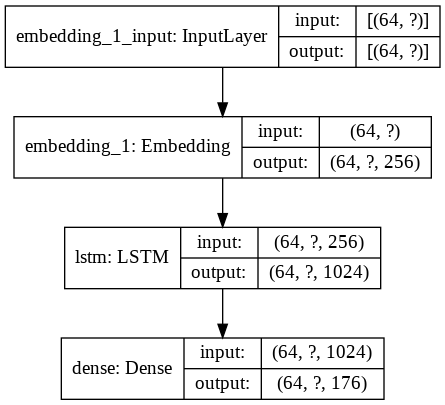

In [46]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)


For each character, the model looks up the embedding, runs the LSTM one time-step with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

## Trying the model before training
Let's play around with un-trained model to see its interface (what input do we need and what output will we have) and let's see what model predicts before the training:

In [47]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [48]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 2.8052635e-03  2.2147680e-03  2.6683484e-03 -2.7320436e-03
  6.0293451e-03  6.7881616e-03  3.4301291e-05  3.5296765e-04
 -7.2545306e-05 -5.9101623e-03 -2.2190770e-03  1.4771495e-03
 -1.2176925e-03  3.2298851e-03 -3.6289804e-03  1.4591768e-03
 -3.4608890e-04  2.0906546e-03  5.5405353e-03  2.4234885e-03
 -1.2571634e-03 -2.5157218e-03 -1.5683675e-03  5.4463497e-03
 -4.6327566e-03  3.5604965e-03  9.9585264e-04  1.2030762e-03
  2.2485291e-03  1.8297568e-03  3.8964751e-03  2.7754882e-04
  2.2451603e-03  5.9204787e-05 -5.7749483e-03  7.6303715e-03
 -2.2102497e-03  1.5722802e-04  9.9786313e-04 -6.0532498e-04
  3.7763037e-03  1.7667125e-03  2.0181737e-03  1.0942749e-03
  3.4537551e-03  3.2117707e-03 -3.5146479e-03 -2.1304670e-03
 -3.3122066e-03 -1.7564879e-03  5.5530956e-03 -2.4748950e-03
  2.4931584e-03  6.7037164e-04  1.7173450e-03  5.4560639e-03
 -2.4755683e-03  3.9952388e-03 -3.5602090e-04  4.1971444e-03
  2.0498894e-03 -

For each input character, the example_batch_predictions array contains a vector of probabilities of what the next character might be. If probability at position 15 in that vector is, let's say, 0.3 and the probability at position 25 is 1.1 it means that we should better pick the character with the index 25 as next following character.
Since we want our network to generate different recipes (even for the same input), we can't just pick the maximum probability value. In this case, we will end up with the same recipe being predicted by the network over and over again. What we will do instead is drawing samples from predictions (like the one printed above) by using tf.random.categorical() function. It will bring some fuzziness to the network. For example, let's say we have character H as an input, then, by sampling from categorical distribution, our network may predict not only the word He, but also words Hello, and Hi etc.

### Understanding how tf.random.categorical works

In [49]:
# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0"
# (element with index 0) is low but the probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 1 2]], shape=(1, 5), dtype=int64)


## Sampling from LSTM predictions

In [50]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [51]:
sampled_indices[:100]

array([ 45,  71,  66,  62,  90, 139, 122,  50,  35,  95, 146,  91, 104,
        19,  65,  42,  83, 112, 108,  54,  71,  44,   3,  90, 105,  87,
        52, 118,  82, 140,  52, 173,  98,  11,  16,  77,  32,  36,  51,
         4,  33,  14,  33,  72,  93,  93, 123,  31,  68,  49,  25, 154,
       127, 172, 151,  21,  87,  38,  33, 114, 168, 163,   8,  86, 170,
        88,  35,  48,  77, 131, 163,  84, 128,  85, 150, 165, 151, 150,
         6, 153, 152,  43,  14,  14,  88,  13,   6, 105, 134, 174,  37,
       139, 119,  82,  81,  57,  67,  87, 144,  20])

### We may see now what our untrained model actually predicts:

In [52]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   E a s y   L a s a g n a   I I \n \n 🥕 \n \n •   1   p o u n d   l e a n   g r o u n d   b e e f   \n'

Next char prediction:
 "B 9 7 6 ™ ˚ ¾ R C — “ î ¼ b : ( ! ï < I 9 A a ™ + % 🥕 ê * » 🥕 € ½ d \n ° ︎ - 📗 t S u S U ? ? ‚ ▪ ' T"


## Training the model

We want to train our model to generate recipes as similar to the real ones as possible. We will use all data from the dataset for training. There is no need to extract test or validation sub-sets in this case.

Attach an optimizer, and a loss function

We're going to use tf.keras.optimizers.Adam optimizer with tf.keras.losses.sparse_categorical_crossentropy() loss function to train the model:

In [53]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.167224


## Compiling the Model

In [54]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss='sparse_categorical_crossentropy'
)

## Configuring callbacks

Early stopping callback

For model training process we may configure a tf.keras.callbacks.EarlyStopping callback. It will stop the training automatically in case if model is not improving for several epochs anymore:

In [55]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

Model checkpoints callback

Let's also configure a tf.keras.callbacks.ModelCheckpoint checkpoint that will allow us to periodically save trained weights to the file so that we could restore the model from weights afterwards.

In [56]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Model saving callback

Callback to save the Keras model or model weights at some frequency.

In [57]:
save_model_callback = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Homemade RecipeBowl/Model.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=500)

## Execute the training

Let's train our model for 500 epochs with 1500 steps per each epoch. For each epoch step, the batch of 64 recipes will be fetched, and gradient descent will be executed for those 64 recipes of length 2000 step by step.

If you're experimenting with training parameters, then it might make sense to reduce the number of epochs to, let's say 20 along with the number of steps per epoch and then see how the model performs under that conditions. If the model improves its performance, you may add more data (steps and epochs) to the training process. It might save you some time while you adjust parameters.

In [58]:
EPOCHS = 500
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1500

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           500
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  1500


In [ ]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        save_model_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save("/content/gdrive/My Drive/Homemade RecipeBowl/"+model_name, save_format='h5')


Epoch 2/5
 4/15 [=======>......................] - ETA: 27s - loss: 1.2402
Epoch 00002: loss improved from inf to 1.21645, saving model to /content/gdrive/My Drive/Homemade RecipeBowl/Model.h5
 9/15 [=================>............] - ETA: 17s - loss: 1.2038
Epoch 00002: loss improved from 1.21645 to 1.19655, saving model to /content/gdrive/My Drive/Homemade RecipeBowl/Model.h5
14/15 [===========================>..] - ETA: 3s - loss: 1.1713
Epoch 00002: loss improved from 1.19655 to 1.16591, saving model to /content/gdrive/My Drive/Homemade RecipeBowl/Model.h5
15/15 [==============================] - 49s 3s/step - loss: 1.1659
Epoch 3/5
 4/15 [=======>......................] - ETA: 25s - loss: 1.1339
Epoch 00003: loss improved from 1.16591 to 1.12651, saving model to /content/gdrive/My Drive/Homemade RecipeBowl/Model.h5
 9/15 [=================>............] - ETA: 18s - loss: 1.1391
Epoch 00003: loss did not improve from 1.12651
14/15 [===========================>..] - ETA: 3s - loss: 

Checking for parameter for Monitor attribute


In [ ]:
for key in history.history:
  print(key)

loss


## Visualizing training progress

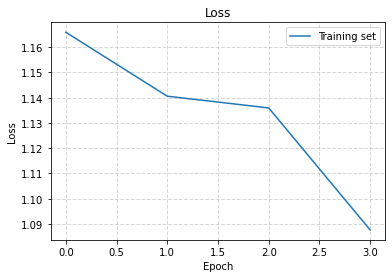

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [ ]:
simplified_batch_size = 1
model_simplified = build_model(VOCABULARY_SIZE, 256, 1024, simplified_batch_size)
model_simplified.load_weights(filepath_of_trained_model)
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))
model_simplified.summary()

In [ ]:
model_simplified.input_shape

(1, None)

In [ ]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [ ]:
generate_combinations(model_simplified)

Attempt: "" + 1.0
-----------------------------------
📗 Gilli Daphing Onion Gravy

🥕

• 1 (3 pound) whole beef tenderloin, cut into pieces 
• 1/2 teaspoon ground black pepper 
• 2 teaspoons pureed chopped garlic 
• 2 zucchini (about 2 pounds), cut into thin wedges 
• 3/4 cup unpopped potatoes 
• 1 (1 ounce) envelope dry onion soup mix 

📝

▪︎ Place pork loin causesion into a sided skillet to measure 2 inches in diameter; cook until fragrant, 2 to 3 minutes. Reduce heat to low, and then make a prepared mushroom crepe plain or removing directions for about 5 minutes.
▪︎ Meanwhile, saute onion and carrots in oil until softened and translucent, about 3 minutes more. Remove from heat. Stir in sour cream, garlic, and tarragon and pour over pork chops and sprinkle with seafood seasoning.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

KeyboardInterrupt: ignored